In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import shap
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
import shap

In [3]:
# Import the one-hot encoded data.
data = pd.read_csv('full_data_ohe.csv')
# An error from writing with index.
data = data.drop(columns=['Unnamed: 0'])
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

FileNotFoundError: [Errno 2] No such file or directory: 'full_data_ohe.csv'

In [9]:
features = data.drop(columns=['attack_cat', 'label'])
label = data['label']
attack_cat = data['attack_cat']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)
scaled_data_df = pd.DataFrame(scaled_data, columns=features.columns)
scaled_data_df['attack_cat'] = attack_cat.reset_index(drop=True)
# Split 20% test.
X_train, X_test, y_train, y_test = train_test_split(scaled_data_df, label, test_size=0.2, random_state=42)
# Drop attack cat before running model and store for later evaluation indexing.
test_attack_cat = X_test['attack_cat']
X_train = X_train.drop(columns=['attack_cat'])
print(X_test['attack_cat'].value_counts())
X_test = X_test.drop(columns=['attack_cat'])
# Check label distribution.

attack_cat
Normal            443831
Generic            43110
Exploits            8732
Fuzzers             4784
DoS                 3315
Reconnaissance      2850
Analysis             550
Backdoor             477
Shellcode            320
Worms                 41
Name: count, dtype: int64


In [10]:
# Run RandomForest with default settings.
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    443831
           1       0.99      0.99      0.99     64179

    accuracy                           1.00    508010
   macro avg       0.99      0.99      0.99    508010
weighted avg       1.00      1.00      1.00    508010

[[442983    848]
 [   925  63254]]


In [11]:
# Add labels back to the data and create a label list.
X_test['predicted_label'] = y_pred
X_test['true_label'] = y_test.values
X_test['attack_cat'] = test_attack_cat
X_test = X_test.reset_index(drop=True)
attack_categories = X_test['attack_cat'].unique()
# Iterate for each category label and group evaluation results and print.
for category in attack_categories:
    print(f"Evaluation for attack category: {category}")
    category_data = X_test[X_test['attack_cat'] == category]
    y_true_category = category_data['true_label']
    y_pred_category = category_data['predicted_label']
    correct_predictions = (y_true_category == y_pred_category).sum()
    total_samples = len(y_true_category)
    accuracy = accuracy_score(y_true_category, y_pred_category)
    precision = precision_score(y_true_category, y_pred_category, zero_division=0)
    recall = recall_score(y_true_category, y_pred_category, zero_division=0)
    f1 = f1_score(y_true_category, y_pred_category, zero_division=0)
    print(f"Total samples: {total_samples}")
    print(f"Correct predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print("\nClassification Report:\n", classification_report(y_true_category, y_pred_category, zero_division=0))
    print("-" * 50)

Evaluation for attack category: Normal
Total samples: 443831
Correct predictions: 442983
Accuracy: 0.9980893628430642
Precision: 0.0
Recall: 0.0
F1-Score: 0.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    443831
           1       0.00      0.00      0.00         0

    accuracy                           1.00    443831
   macro avg       0.50      0.50      0.50    443831
weighted avg       1.00      1.00      1.00    443831

--------------------------------------------------
Evaluation for attack category: Generic
Total samples: 43110
Correct predictions: 43102
Accuracy: 0.9998144282069126
Precision: 1.0
Recall: 0.9998144282069126
F1-Score: 0.9999072054934348

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00     43110

    accuracy                           1.00     43110
   macr

In [12]:
import pickle
X_test.to_csv('X_test.csv')
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

In [13]:
# Get correct and incorrect predictions. Create DataFrames then drop the columns.
X_test['incorrect_predictions'] = X_test['predicted_label'] != X_test['true_label']
X_test['correct_predictions'] = X_test['predicted_label'] == X_test['true_label']
incorrect_predictions = X_test[X_test['incorrect_predictions'] == True]
correct_predictions = X_test[X_test['correct_predictions'] == True]
sdata1 = incorrect_predictions.reset_index(drop=True).drop(columns=['correct_predictions', 'incorrect_predictions', 'predicted_label'])
sdata2 = correct_predictions.reset_index(drop=True).drop(columns=['correct_predictions', 'incorrect_predictions', 'predicted_label'])
# Validate.
print("Incorrect Predictions (All):")
print(len(sdata1))
print("Correct Predictions (All):")
print(len(sdata2))

Incorrect Predictions (All):
1773
Correct Predictions (All):
506237


3309
6
(6, 111, 2)
(1000, 111)
(1000, 111, 2)
(6, 111)
Correct Predictions


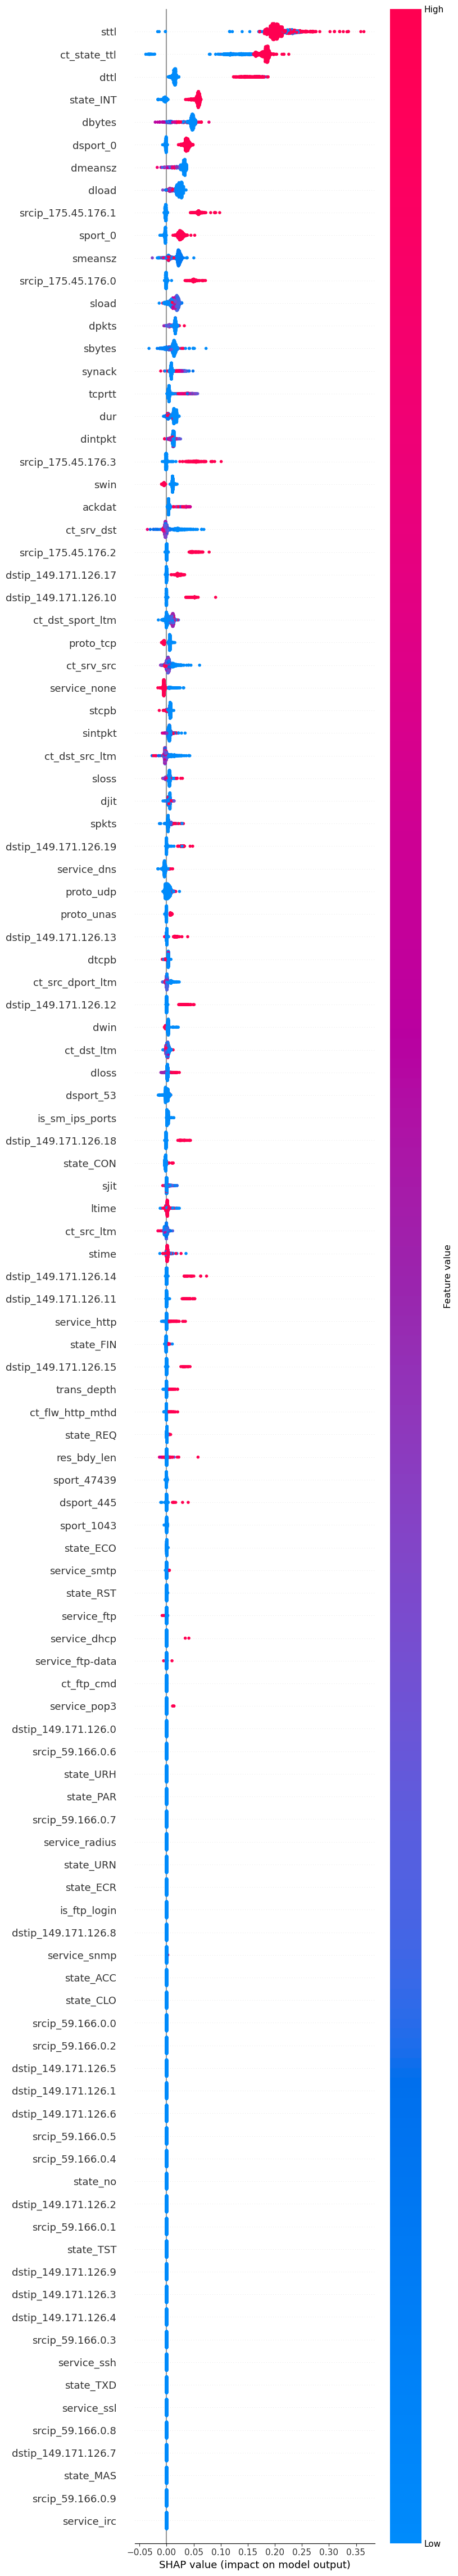

Incorrect Predictions


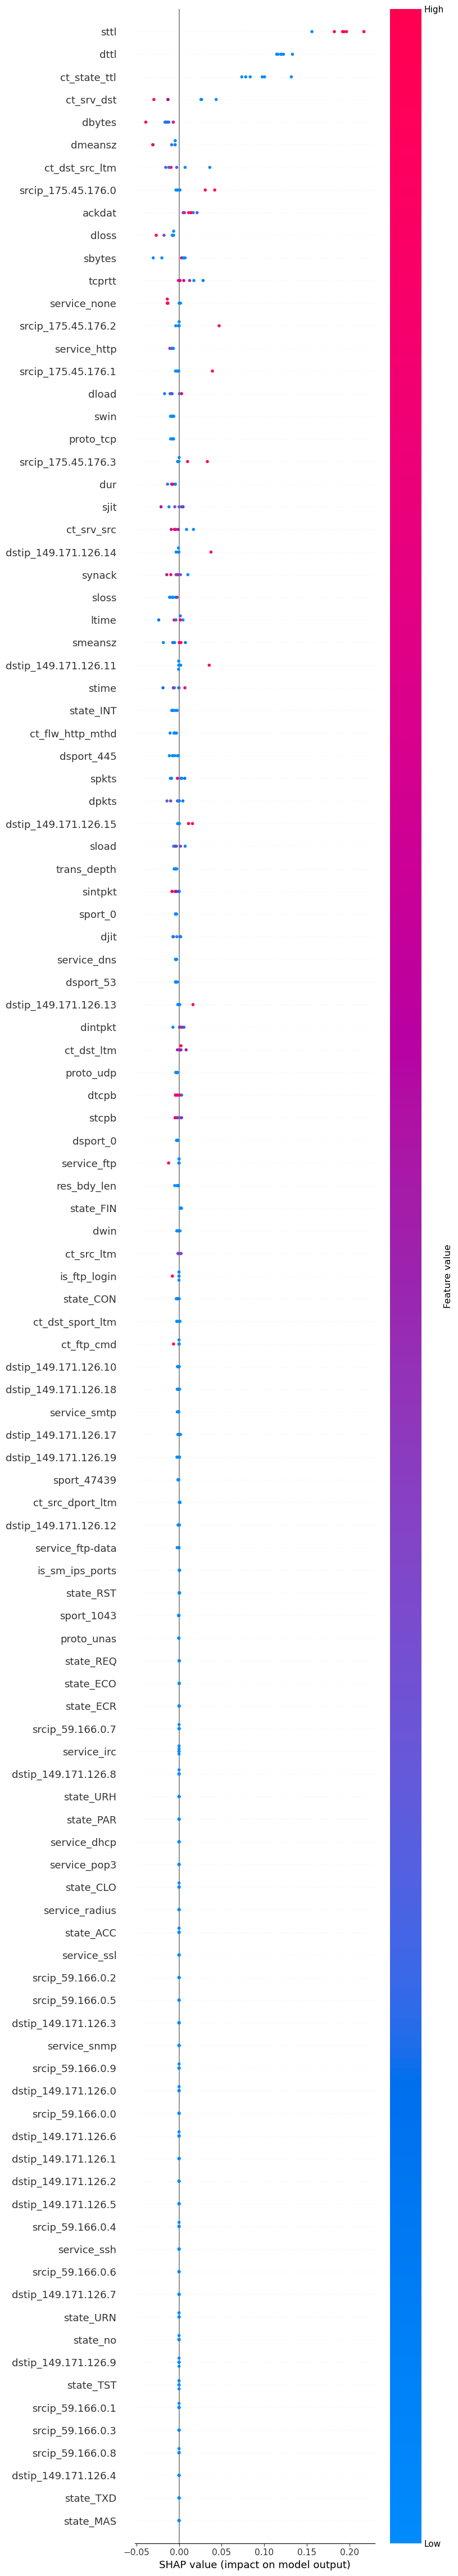

In [14]:
sdata1 = sdata1[sdata1['attack_cat']=='DoS']
sdata2 = sdata2[sdata2['attack_cat']=='DoS']
sdata1 = sdata1.drop(columns=['attack_cat'])
sdata2 = sdata2.drop(columns=['attack_cat'])
dos_correct = sdata2[sdata2['true_label'] == 1]
dos_correct = dos_correct.drop(columns=['true_label'])
dos_incorrect = sdata1[sdata1['true_label'] == 1]
dos_incorrect = dos_incorrect.drop(columns=['true_label'])
print(len(dos_correct))
print(len(dos_incorrect))
dos_correct = dos_correct.sample(n=1000, random_state=42)

# Calculate shap for DoS rows.
# Incorrect Predictions.
explainer = shap.TreeExplainer(rf)
shap_values1 = explainer.shap_values(dos_incorrect)
# Verify shape.
print(shap_values1.shape)
print(dos_correct.shape)
# Correct Predictions.
explainer = shap.TreeExplainer(rf)
shap_values2 = explainer.shap_values(dos_correct)
# Verify shape.
print(shap_values2.shape)
print(dos_incorrect.shape)
print('Correct Predictions')
shap.summary_plot(shap_values2[:, :, 1], dos_correct, max_display=len(dos_correct.columns), show=True)
print('Incorrect Predictions')
shap.summary_plot(shap_values1[:, :, 1], dos_incorrect, max_display=len(dos_incorrect.columns), show=True)

In [15]:
features = data.drop(columns=['attack_cat', 'label'])
label = data['label']
attack_cat = data['attack_cat']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)
scaled_data_df = pd.DataFrame(scaled_data, columns=features.columns)
scaled_data_df['attack_cat'] = attack_cat.reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(scaled_data_df, label, test_size=0.2, random_state=42)
downsample = 0.2
rs = 42
mask = (X_train['attack_cat'].shift(-1) != 1) & (X_train['attack_cat'].shift(1) != 1)
normal_rows = X_train[(X_train['attack_cat'] == 'Normal') & mask]
percentage_to_remove = int(len(normal_rows) * downsample)
rows_to_remove = normal_rows.sample(n=percentage_to_remove, random_state=rs)
X_train = X_train.drop(rows_to_remove.index)
y_train = y_train.loc[~y_train.index.isin(rows_to_remove.index)]
print(f"Downsampled Rows from X_train: {len(rows_to_remove)}")
X_train = X_train.drop(columns=['attack_cat'])
test_attack_cat = X_test['attack_cat']
print(X_test['attack_cat'].value_counts())
X_test = X_test.drop(columns=['attack_cat'])

Downsampled Rows from X_train: 354986
attack_cat
Normal            443831
Generic            43110
Exploits            8732
Fuzzers             4784
DoS                 3315
Reconnaissance      2850
Analysis             550
Backdoor             477
Shellcode            320
Worms                 41
Name: count, dtype: int64


In [16]:
# Run RandomForest with default settings.
# The increase in accuracy for threats decreases accuracy in Normal labels (could try pooling?).
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    443831
           1       0.98      0.99      0.99     64179

    accuracy                           1.00    508010
   macro avg       0.99      0.99      0.99    508010
weighted avg       1.00      1.00      1.00    508010

[[442700   1131]
 [   762  63417]]


In [17]:
# Add labels back to the data and create a label list.
X_test['predicted_label'] = y_pred
X_test['true_label'] = y_test.values
X_test['attack_cat'] = test_attack_cat
X_test = X_test.reset_index(drop=True)
attack_categories = X_test['attack_cat'].unique()
# Iterate for each category label and group evaluation results and print.
for category in attack_categories:
    print(f"Evaluation for attack category: {category}")
    category_data = X_test[X_test['attack_cat'] == category]
    y_true_category = category_data['true_label']
    y_pred_category = category_data['predicted_label']
    correct_predictions = (y_true_category == y_pred_category).sum()
    total_samples = len(y_true_category)
    accuracy = accuracy_score(y_true_category, y_pred_category)
    precision = precision_score(y_true_category, y_pred_category, zero_division=0)
    recall = recall_score(y_true_category, y_pred_category, zero_division=0)
    f1 = f1_score(y_true_category, y_pred_category, zero_division=0)
    print(f"Total samples: {total_samples}")
    print(f"Correct predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print("\nClassification Report:\n", classification_report(y_true_category, y_pred_category, zero_division=0))
    print("-" * 50)

Evaluation for attack category: Normal
Total samples: 443831
Correct predictions: 442700
Accuracy: 0.9974517327541339
Precision: 0.0
Recall: 0.0
F1-Score: 0.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    443831
           1       0.00      0.00      0.00         0

    accuracy                           1.00    443831
   macro avg       0.50      0.50      0.50    443831
weighted avg       1.00      1.00      1.00    443831

--------------------------------------------------
Evaluation for attack category: Generic
Total samples: 43110
Correct predictions: 43102
Accuracy: 0.9998144282069126
Precision: 1.0
Recall: 0.9998144282069126
F1-Score: 0.9999072054934348

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00     43110

    accuracy                           1.00     43110
   macr